In [1]:
from itertools import product
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from basis_expansions import (Binner, Polynomial, 
                              LinearSpline, CubicSpline,
                              NaturalCubicSpline)
from simulation import (run_simulation_expreiment, 
                        plot_simulation_expreiment, 
                        make_random_train_test,
                        run_residual_simulation)

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def signal(x):
    return (x*x*x*(x-1) 
            + 2*(1/(1 + np.exp(-0.5*(x - 0.5)))) 
            - 3.5*(x > 0.2)*(x < 0.5)*(x - 0.2)*(x - 0.5)
            - 0.95)

x = np.random.uniform(size=100)
y = signal(x) + np.random.normal(scale=0.05, size=100)

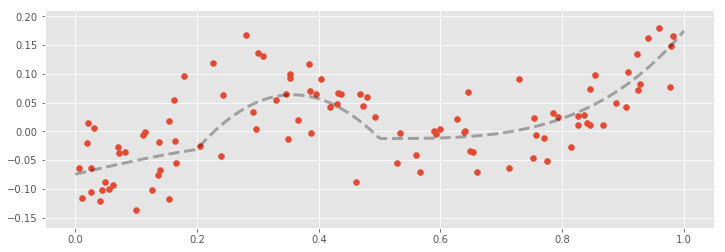

In [3]:
fig, ax = plt.subplots(figsize=(12, 4))
t = np.linspace(0, 1, num=250)

ax.scatter(x, y)
ax.plot(t, signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.3)

# Binned regression with dummy varaibles.

In [4]:
def make_binned_regression(n_cuts):
    return Pipeline([
        ('binner', Binner(0, 1, n_cuts=n_cuts)),
        ('regression', LinearRegression(fit_intercept=False))
    ])

regressions = {}
for n_cuts in range(1, 24):
    regressions[n_cuts] = make_binned_regression(n_cuts)
    regressions[n_cuts].fit(x, y)

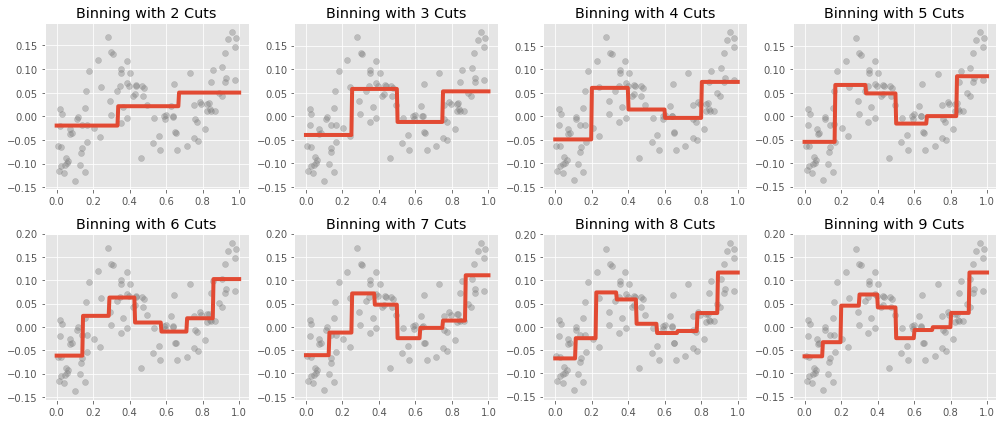

In [5]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

t = np.linspace(0, 1, 250)
for n_cuts, ax in enumerate(ax.flatten(), start=2):
    ax.plot(t, regressions[n_cuts].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.4, color="grey")
    ax.set_title("Binning with {} Cuts".format(n_cuts))

fig.tight_layout()

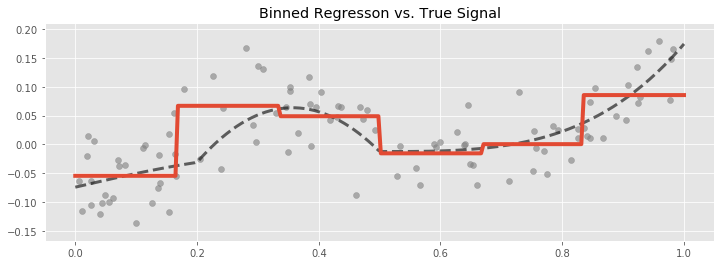

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
t = np.linspace(0, 1, num=250)

ax.scatter(x, y, alpha=0.6, color="grey")
ax.plot(t, signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.6)
ax.plot(t, regressions[5].predict(t.reshape(-1, 1)), linewidth=4)
ax.set_title("Binned Regresson vs. True Signal")

# Regression with polynomial expansion

In [7]:
def make_polynomial_regression(degree):
    return Pipeline([
        ('std', StandardScaler()),
        ('poly', Polynomial(degree=degree)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for degree in range(1, 30):
    regressions[degree] = make_polynomial_regression(degree)
    regressions[degree].fit(x.reshape(-1, 1), y)

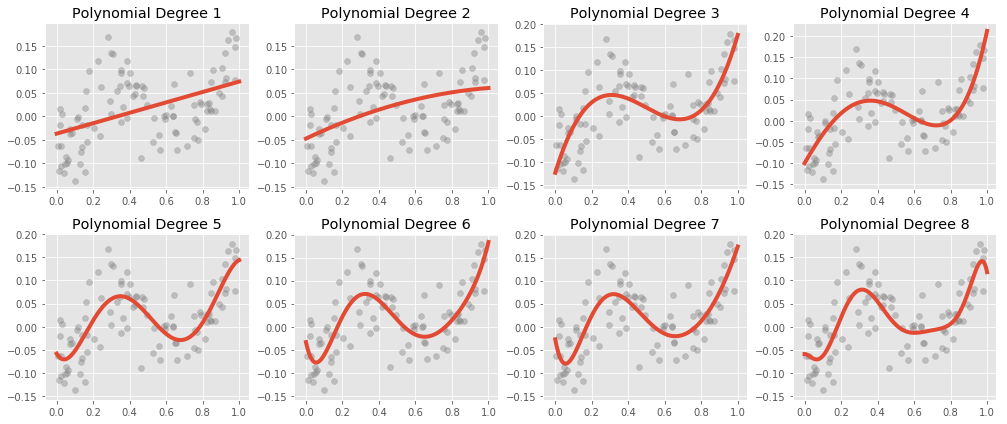

In [8]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    degree = i + 1
    ax.plot(t, regressions[degree].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.4, color="grey")
    ax.set_title("Polynomial Degree {}".format(degree))
    
fig.tight_layout()

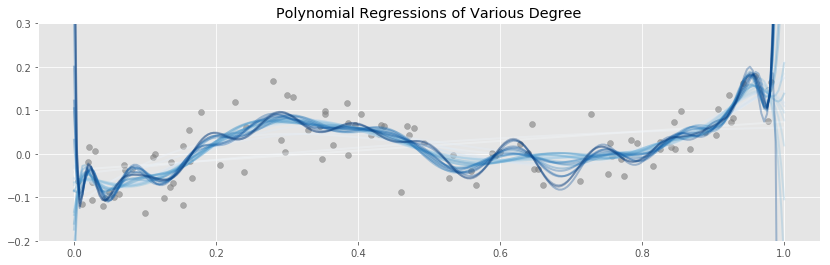

In [9]:
fig, ax = plt.subplots(figsize=(14, 4))

from matplotlib import cm

ax.scatter(x, y, alpha=0.6, color="grey")
colors = [cm.Blues(t) for t in np.linspace(0.0, 1.0, 30)]

for i, degree in enumerate(range(1, 30)):
    ax.plot(t, regressions[degree].predict(t.reshape(-1, 1)), 
            linewidth=2, alpha=0.33, color=colors[i])
ax.set_ylim(-0.2, 0.3)
ax.set_title("Polynomial Regressions of Various Degree")

In [10]:
degrees = [5, 10, 20]
regressors = [make_polynomial_regression(degree) for degree in degrees]
test_xs, test_errors = run_residual_simulation(signal, regressors, 50, 100)

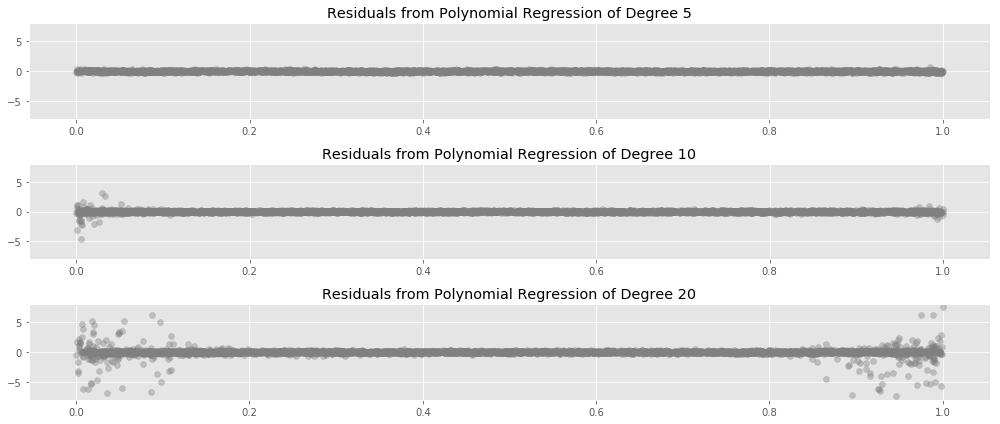

In [12]:
fig, axs = plt.subplots(len(degrees), figsize=(14, 6))

for (i, degree), sim in product(enumerate(degrees), range(100)):
    axs[i].scatter(test_xs[i, sim, :], test_errors[i, sim, :], color="grey", alpha=0.4)
    axs[i].set_title("Residuals from Polynomial Regression of Degree {}".format(degree))
    axs[i].set_ylim(-8, 8)
fig.tight_layout()

# Regression with piecewise linear expansion

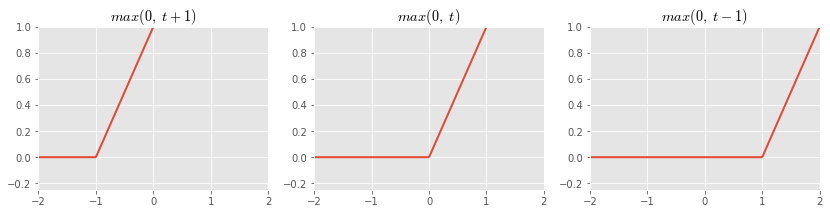

In [13]:
t = np.linspace(-2, 2, num=250)
knots = [-1, 0, 1]
titles = ["$max(0, \ t + 1)$", "$max(0, \ t)$", "$max(0, \ t - 1)$"]

fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i, (knot, title) in enumerate(zip(knots, titles)):
    axs[i].plot(t, np.maximum(0, t - knot))
    axs[i].set_ylim(-0.25, 1)
    axs[i].set_xlim(-2, 2)
    axs[i].set_title(title)

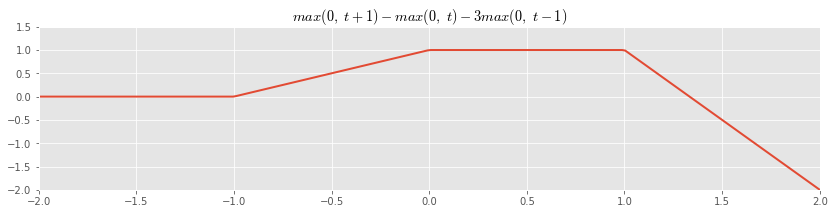

In [14]:
fig, ax = plt.subplots(figsize=(14, 3))

ax.plot(t, np.maximum(0, t + 1) - np.maximum(0, t) - 3*np.maximum(0, t - 1))
ax.set_ylim(-2, 1.5)
ax.set_xlim(-2, 2)
ax.set_title("$max(0, \ t + 1) - max(0, \ t) - 3 max(0, \ t - 1)$")

In [15]:
def make_pl_regression(n_knots):
    return Pipeline([
        ('pl', LinearSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for n_knots in range(2, 25):
    regressions[n_knots] = make_pl_regression(n_knots)
    regressions[n_knots].fit(x.reshape(-1, 1), y)

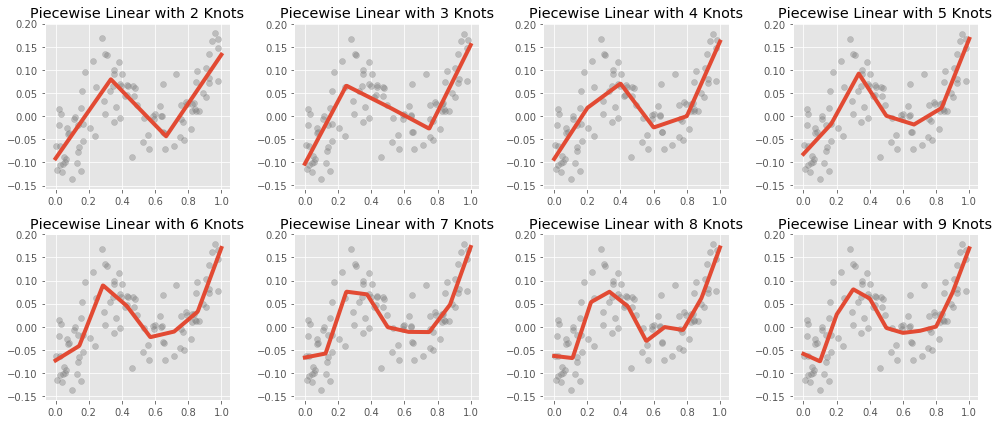

In [16]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_knots = i + 2
    ax.plot(t, regressions[n_knots].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.4, color="grey")
    ax.set_title("Piecewise Linear with {} Knots".format(n_knots))
    
fig.tight_layout()

In [17]:
n_knots = [5, 10, 20]
regressors = [make_pl_regression(n_knot) for n_knot in n_knots]
test_xs, test_errors = run_residual_simulation(signal, regressors, 50, 100)

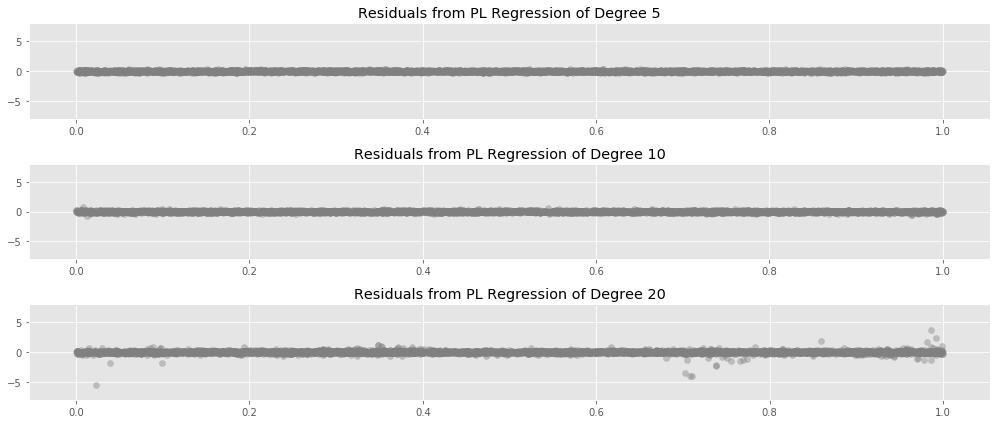

In [19]:
fig, axs = plt.subplots(len(degrees), figsize=(14, 6))

for (i, n_knot), sim in product(enumerate(n_knots), range(100)):
    axs[i].scatter(test_xs[i, sim, :], test_errors[i, sim, :], color="grey", alpha=0.4)
    axs[i].set_title("Residuals from PL Regression of Degree {}".format(n_knot))
    axs[i].set_ylim(-8, 8)
fig.tight_layout()

# Regression with piecewise cubic expansion

In [20]:
def make_pw_cubic_regression(n_knots):
    return Pipeline([
        ('pw_cubic', CubicSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for n_knots in range(2, 25):
    regressions[n_knots] = make_pw_cubic_regression(n_knots)
    regressions[n_knots].fit(x.reshape(-1, 1), y)

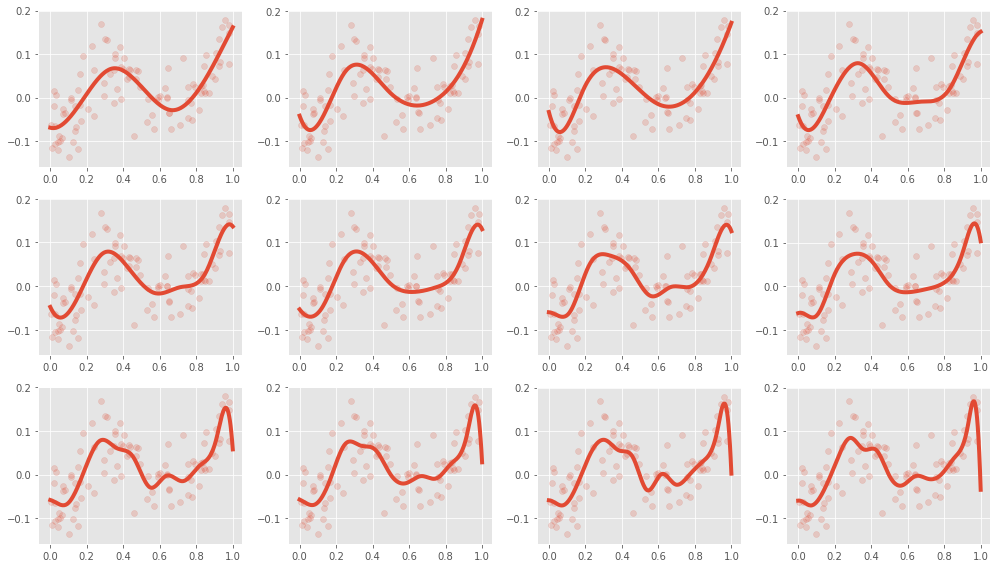

In [21]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_knots = i + 2
    ax.plot(t, regressions[n_knots].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.2)


    
fig.tight_layout()

# Regression with piecewise natural cubic expansion

In [22]:
def make_natural_cubic_regression(n_knots):
    return Pipeline([
        ('nat_cubic', NaturalCubicSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for n_knots in range(2, 25):
    regressions[n_knots] = make_natural_cubic_regression(n_knots)
    regressions[n_knots].fit(x.reshape(-1, 1), y)

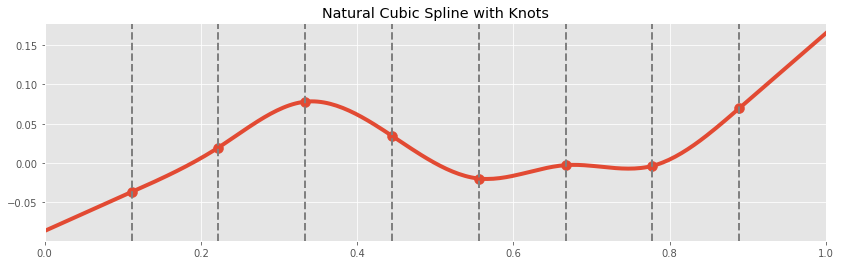

In [23]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(t, regressions[8].predict(t.reshape(-1, 1)), linewidth=4)

knots = regressions[8].get_params()['nat_cubic__knots']
ax.scatter([knots], regressions[8].predict(np.array(knots).reshape(-1, 1)), s=100)

for knot in knots:
    ax.axvline(knot, linestyle='--', color='grey')
ax.set_xlim(0, 1)
ax.set_title("Natural Cubic Spline with Knots")

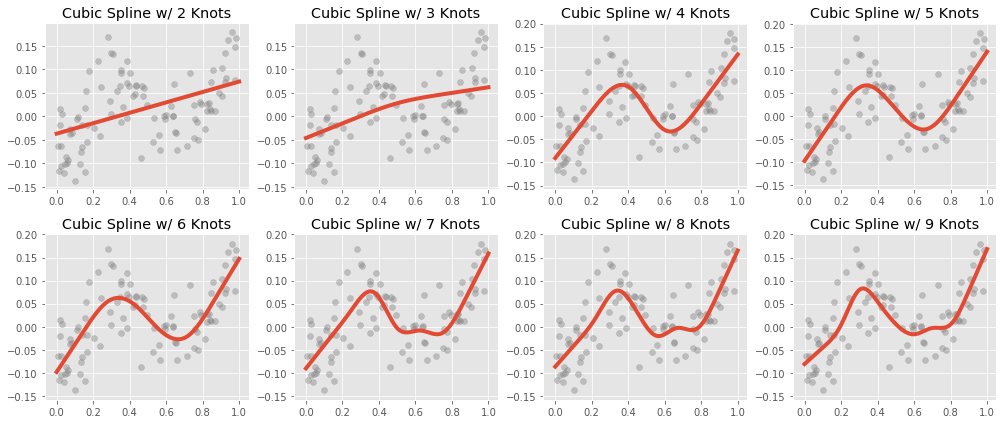

In [24]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_knots = i + 2
    ax.plot(t, regressions[n_knots].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.4, color="grey")
    ax.set_title("Cubic Spline w/ {} Knots".format(n_knots))

fig.tight_layout()

In [25]:
n_knots = [5, 10, 20]
regressors = [make_natural_cubic_regression(n_knot) for n_knot in n_knots]
test_xs, test_errors = run_residual_simulation(signal, regressors, 50, 100)

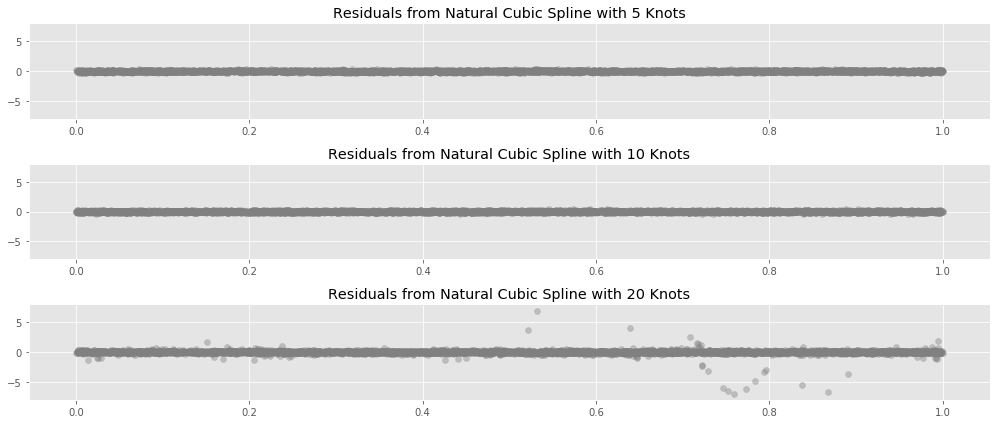

In [27]:
fig, axs = plt.subplots(len(degrees), figsize=(14, 6))

for (i, n_knot), sim in product(enumerate(n_knots), range(100)):
    axs[i].scatter(test_xs[i, sim, :], test_errors[i, sim, :], color="grey", alpha=0.4)
    axs[i].set_title("Residuals from Natural Cubic Spline with {} Knots".format(n_knot))
    axs[i].set_ylim(-8, 8)
fig.tight_layout()

## Examples of all

In [28]:
regressions = [
    {'model': make_binned_regression(5), 
         'title': "Binning Expansion, 6 Bins"},
    
    {'model': make_polynomial_regression(6) , 
         'title': "Polynomial Regression, Degree 6"},
    
    {'model': make_pl_regression(6), 
          'title': "Linear Spline, 6 Knots"},

    {'model': make_pw_cubic_regression(6) , 
         'title': "Cubic Spline, 6 Knots"},

    {'model': make_natural_cubic_regression(6), 
         'title': "Natural Cubic Spline, 6 Knots"}
]

for reg in regressions:
    reg['model'].fit(x.reshape(-1, 1), y)

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


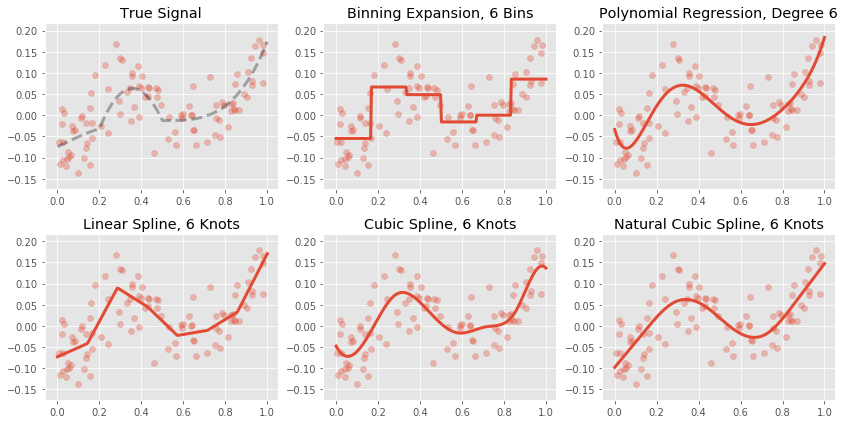

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

axs[0, 0].scatter(x, y, alpha=0.33)
axs[0, 0].plot(t, signal(t), linewidth=3, linestyle="--", 
               color="black", alpha=0.3)
axs[0, 0].set_title("True Signal")

for i, ax in enumerate(axs.flatten()[1:]):
    ax.scatter(x, y, alpha=0.33)
    ax.plot(t, regressions[i]['model'].predict(t), linewidth=3)
    ax.set_title(regressions[i]['title'])
    
fig.tight_layout()

## Examples Applying to Series, Creating Data Frames

In [30]:
s = pd.Series([1, 2, 3, 4, 5, 6], name='s', index=['a', 'b', 'c', 'd', 'e', 'f'])

In [31]:
df = pd.DataFrame([[1, 2], [2, 3]], columns=['x', 'y'])

In [32]:
s.index

Index(['a', 'b', 'c', 'd', 'e', 'f'], dtype='object')

In [33]:
binner = Binner(cutpoints=[2, 4])
binner.fit_transform(s)

,s_bin_neg_infinity_to_2,s_bin_2_to_4,s_bin_4_to_pos_infinity
a,1.0,0.0,0.0
b,1.0,0.0,0.0
c,0.0,1.0,0.0
d,0.0,1.0,0.0
e,0.0,0.0,1.0
f,0.0,0.0,1.0


In [34]:
np.array([True, True, False]) & np.array([False, True, True])

array([False,  True, False], dtype=bool)

## Investigating Performance with Different Smoothers

In [35]:
def linear_signal(x):
    return x

def sin_signal(x):
    return np.sin(2*np.pi*x)

cutpoints = sorted(np.random.uniform(size=6))
def broken_sin_signal(x):
    return  (np.sin(2*np.pi*x) 
             - (cutpoints[0] <= x)*(x <= cutpoints[2]) 
             - (cutpoints[1] <= x)*(x <= cutpoints[2])
             - 2*(cutpoints[3] <= x)*(x <= cutpoints[4]))

def weird_signal(x):
    return (x*x*x*(x-1) 
            + 2*(1/(1 + np.exp(-0.5*(x - 0.5)))) 
            - 3.5*(x > 0.2)*(x < 0.5)*(x - 0.2)*(x - 0.5)
            - 0.95)

In [36]:
degrees_of_freedom = list(range(2, 30))

def make_binned_regression(n_params):
    return Pipeline([
        ('binner', Binner(0, 1, n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=False))
    ])

def make_polynomial_regression(n_params):
    return Pipeline([
        ('std', StandardScaler()),
        ('poly', Polynomial(n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

def make_pl_regression(n_params):
    return Pipeline([
        ('pl', LinearSpline(0, 1, n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

def make_natural_cubic_regression(n_params):
    return Pipeline([
        ('nat_cubic', NaturalCubicSpline(0, 1, n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

def make_non_linear_regressions(regression_maker, degrees_of_freedom):
    return [regression_maker(dof) for dof in degrees_of_freedom]

binned_regressors = make_non_linear_regressions(make_binned_regression,
                                                degrees_of_freedom)
polynomial_regressors = make_non_linear_regressions(make_polynomial_regression,
                                                    degrees_of_freedom)
pl_regressors = make_non_linear_regressions(make_pl_regression,
                                            degrees_of_freedom)
ncs_regressors = make_non_linear_regressions(make_natural_cubic_regression,
                                             degrees_of_freedom)

regressors = {
    "binned": binned_regressors,
    "polynomial": polynomial_regressors,
    "pl": pl_regressors,
    "ncs": ncs_regressors
}

## Fitting to a Linear Signal

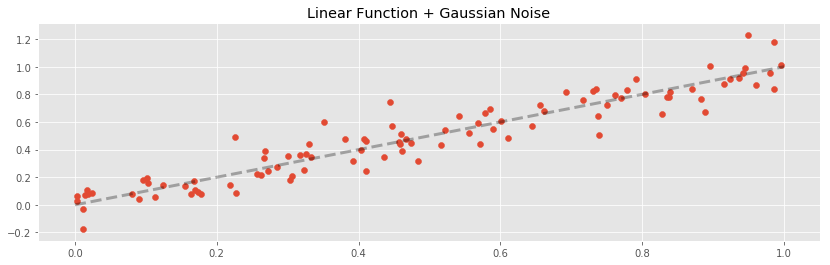

In [37]:
fig, ax = plt.subplots(figsize=(14, 4))
t = np.linspace(0, 1, num=250)

x = np.random.uniform(size=100)
y = linear_signal(x) + np.random.normal(scale=0.1, size=100)
ax.scatter(x, y)
ax.plot(t, linear_signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.3)

ax.set_title("Linear Function + Gaussian Noise")

In [38]:
binned_mean_errors, binned_std_errors = run_simulation_expreiment(
    linear_signal, binned_regressors, sd=0.5)
polynomial_mean_errors, polynomial_std_errors = run_simulation_expreiment(
    linear_signal, polynomial_regressors, sd=0.5)
pl_mean_errors, pl_std_errors = run_simulation_expreiment(
    linear_signal, pl_regressors, sd=0.5)
ncs_mean_errors, ncs_std_errors = run_simulation_expreiment(
    linear_signal, ncs_regressors, sd=0.5)

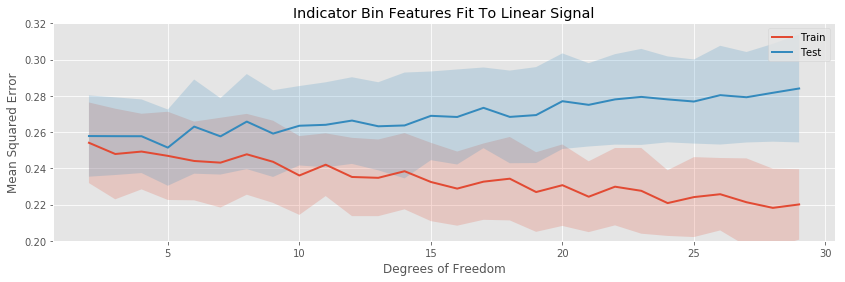

In [39]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, 
    degrees_of_freedom, binned_mean_errors, binned_std_errors)
ax.set_ylim(0.2, 0.32)
ax.set_title("Indicator Bin Features Fit To Linear Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

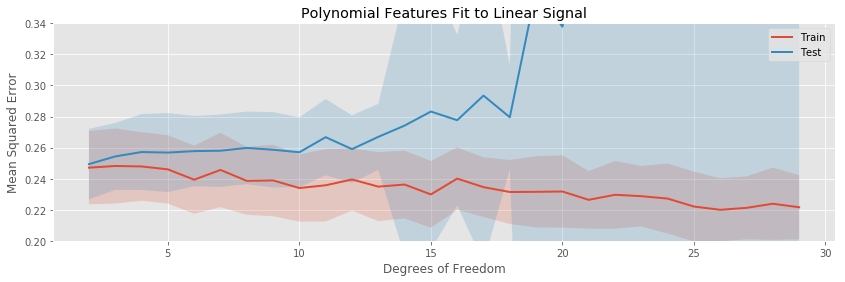

In [40]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, polynomial_mean_errors, polynomial_std_errors)
ax.set_ylim(0.2, 0.34)
ax.set_title("Polynomial Features Fit to Linear Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

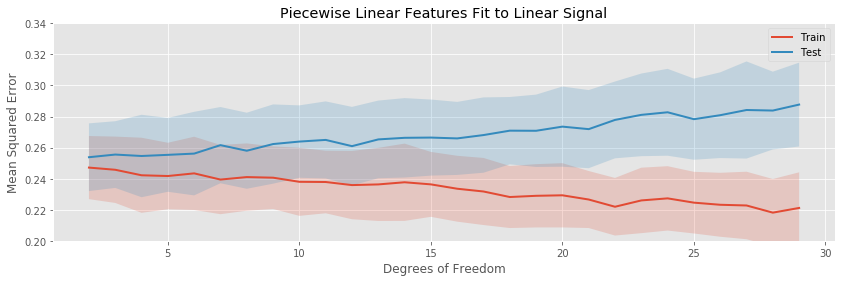

In [41]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, pl_mean_errors, pl_std_errors)
ax.set_ylim(0.2, 0.34)
ax.set_title("Piecewise Linear Features Fit to Linear Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

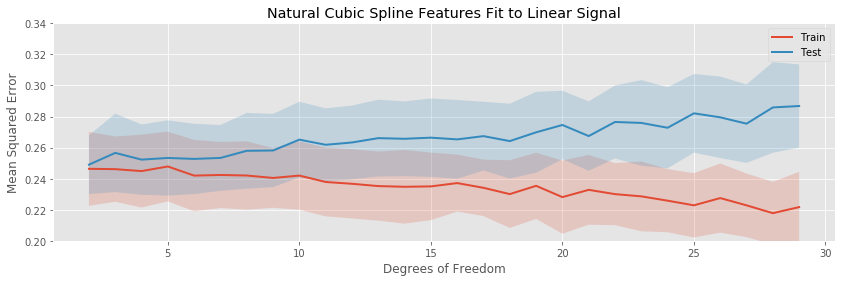

In [42]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, ncs_mean_errors, ncs_std_errors)
ax.set_ylim(0.2, 0.34)
ax.set_title("Natural Cubic Spline Features Fit to Linear Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

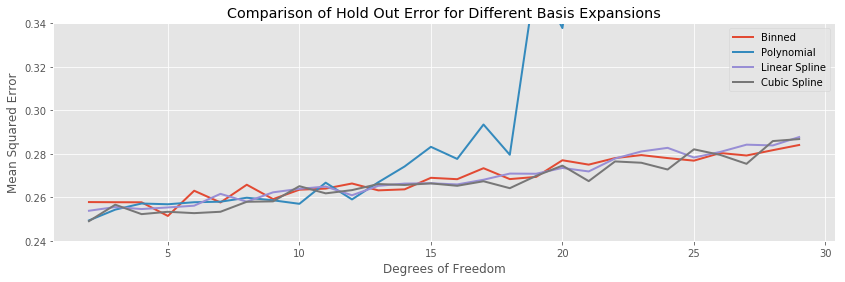

In [43]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_mean_errors[1], label="Binned")
ax.plot(degrees_of_freedom, polynomial_mean_errors[1], label="Polynomial")
ax.plot(degrees_of_freedom, pl_mean_errors[1], label="Linear Spline")
ax.plot(degrees_of_freedom, ncs_mean_errors[1], label="Cubic Spline")
ax.set_ylim(0.24, 0.34)

ax.legend()
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Comparison of Hold Out Error for Different Basis Expansions")

## Fitting to a Sinusoidal Signal

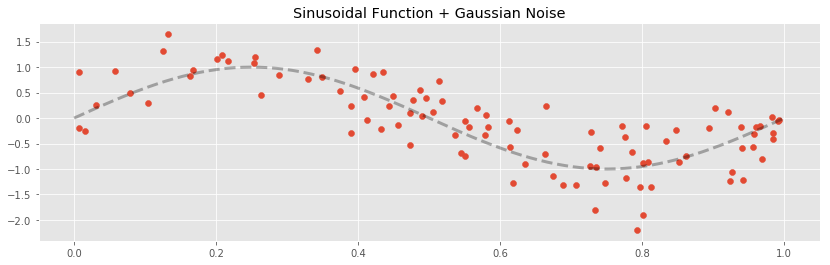

In [65]:
fig, ax = plt.subplots(figsize=(14, 4))
t = np.linspace(0, 1, num=250)

x = np.random.uniform(size=100)
y = sin_signal(x) + np.random.normal(scale=0.5, size=100)
ax.scatter(x, y)
ax.plot(t, sin_signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.3)
ax.set_title("Sinusoidal Function + Gaussian Noise")

In [45]:
binned_mean_errors, binned_std_errors = run_simulation_expreiment(
    sin_signal, binned_regressors, sd=0.5)
polynomial_mean_errors, polynomial_std_errors = run_simulation_expreiment(
    sin_signal, polynomial_regressors, sd=0.5)
pl_mean_errors, pl_std_errors = run_simulation_expreiment(
    sin_signal, pl_regressors, sd=0.5)
ncs_mean_errors, ncs_std_errors = run_simulation_expreiment(
    sin_signal, ncs_regressors, sd=0.5)

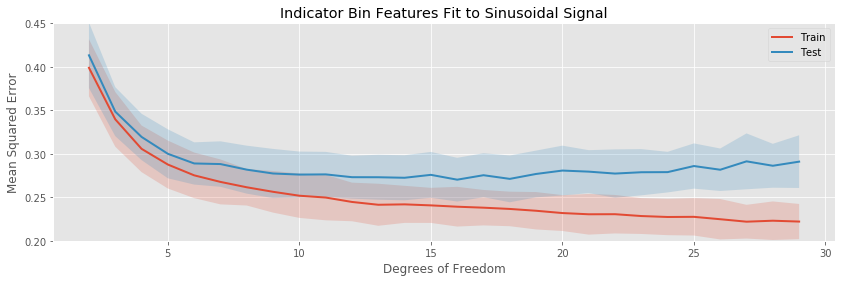

In [46]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, 
    degrees_of_freedom, binned_mean_errors, binned_std_errors)
ax.set_ylim(0.2, 0.45)
ax.set_title("Indicator Bin Features Fit to Sinusoidal Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

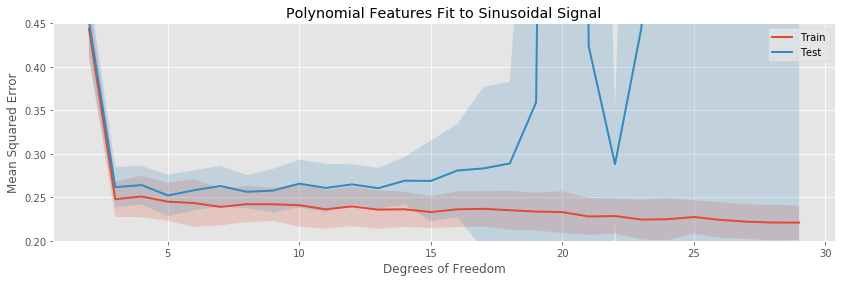

In [47]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, polynomial_mean_errors, polynomial_std_errors)
ax.set_ylim(0.2, 0.45)
ax.set_title("Polynomial Features Fit to Sinusoidal Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

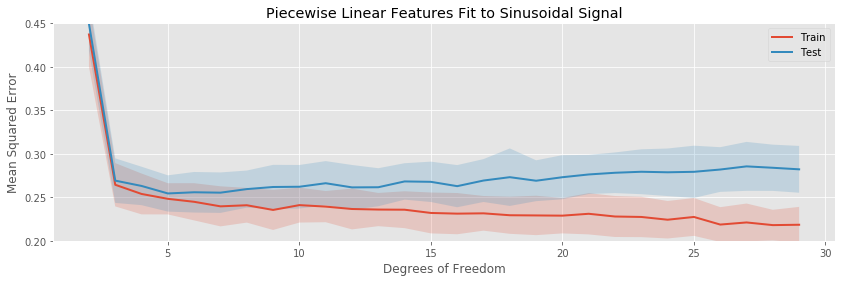

In [48]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, pl_mean_errors, pl_std_errors)
ax.set_ylim(0.2, 0.45)
ax.set_title("Piecewise Linear Features Fit to Sinusoidal Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

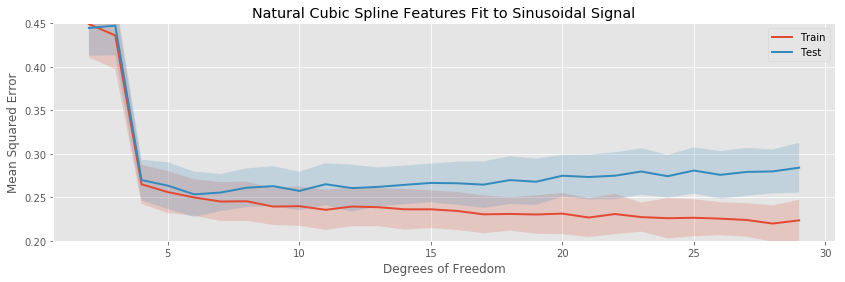

In [49]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, ncs_mean_errors, ncs_std_errors)
ax.set_ylim(0.2, 0.45)
ax.set_title("Natural Cubic Spline Features Fit to Sinusoidal Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

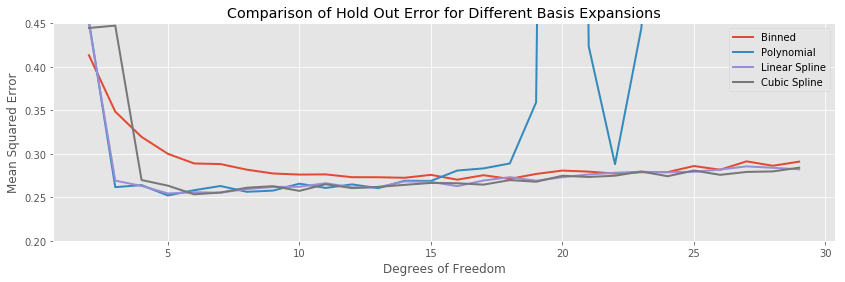

In [50]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_mean_errors[1], label="Binned")
ax.plot(degrees_of_freedom, polynomial_mean_errors[1], label="Polynomial")
ax.plot(degrees_of_freedom, pl_mean_errors[1], label="Linear Spline")
ax.plot(degrees_of_freedom, ncs_mean_errors[1], label="Cubic Spline")
ax.set_ylim(0.2, 0.45)

ax.legend()
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Comparison of Hold Out Error for Different Basis Expansions")

## Fitting to a Broken Sin Signal

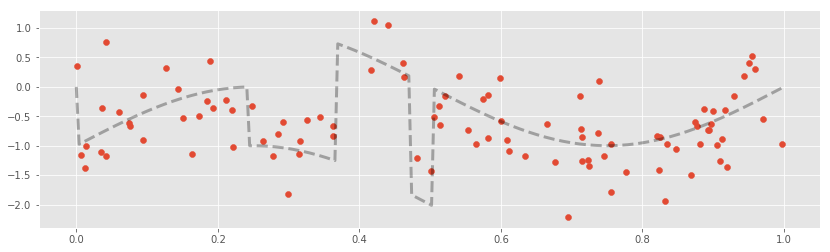

In [51]:
fig, ax = plt.subplots(figsize=(14, 4))
t = np.linspace(0, 1, num=250)

x = np.random.uniform(size=100)
y = broken_sin_signal(x) + np.random.normal(scale=0.5, size=100)
ax.scatter(x, y)
ax.plot(t, broken_sin_signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.3)

In [52]:
binned_mean_errors, binned_std_errors = run_simulation_expreiment(
    broken_sin_signal, binned_regressors, sd=0.05)
polynomial_mean_errors, polynomial_std_errors = run_simulation_expreiment(
    broken_sin_signal, polynomial_regressors, sd=0.05)
pl_mean_errors, pl_std_errors = run_simulation_expreiment(
    broken_sin_signal, pl_regressors, sd=0.05)
ncs_mean_errors, ncs_std_errors = run_simulation_expreiment(
    broken_sin_signal, ncs_regressors, sd=0.05)

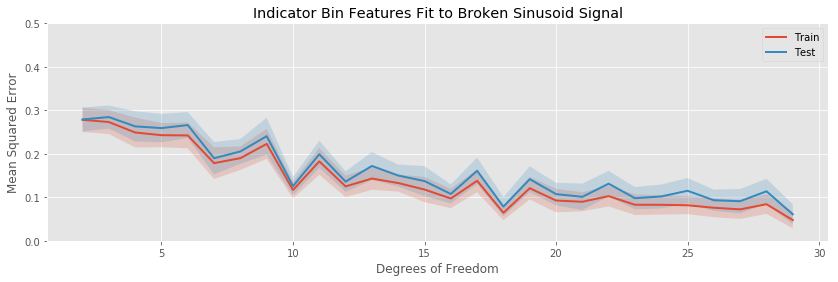

In [53]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, 
    degrees_of_freedom, binned_mean_errors, binned_std_errors)
ax.set_ylim(0.0, 0.5)
ax.set_title("Indicator Bin Features Fit to Broken Sinusoid Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

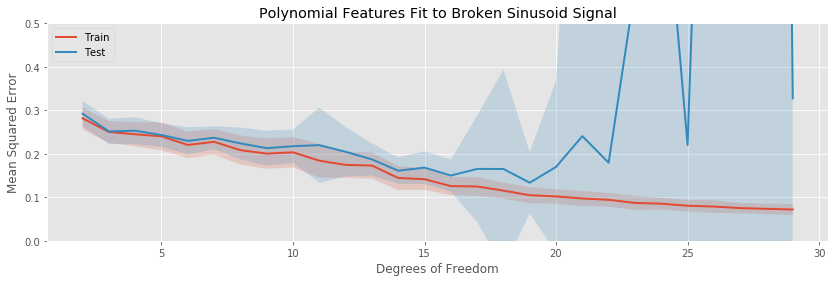

In [54]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, polynomial_mean_errors, polynomial_std_errors)
ax.set_ylim(0.0, 0.5)
ax.set_title("Polynomial Features Fit to Broken Sinusoid Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

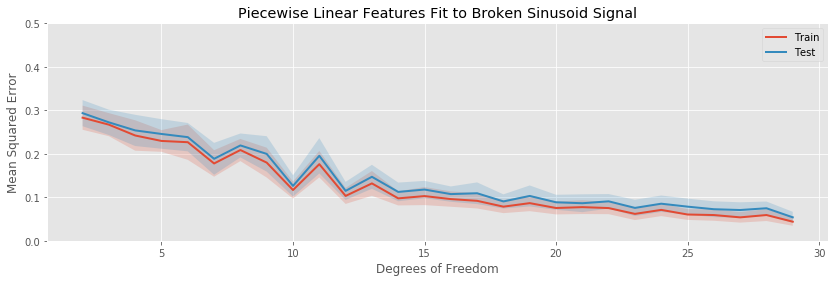

In [55]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, pl_mean_errors, pl_std_errors)
ax.set_ylim(0.0, 0.5)
ax.set_title("Piecewise Linear Features Fit to Broken Sinusoid Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

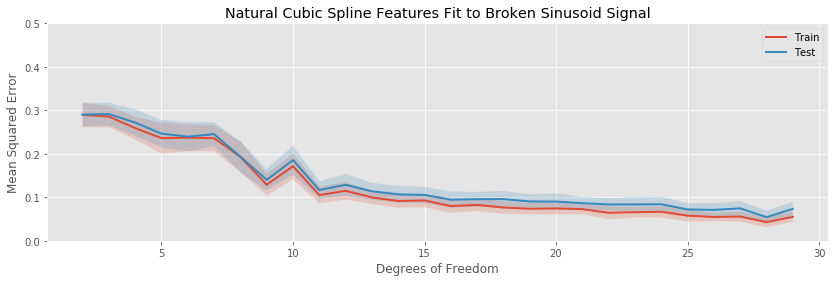

In [56]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, ncs_mean_errors, ncs_std_errors)
ax.set_ylim(0.0, 0.5)
ax.set_title("Natural Cubic Spline Features Fit to Broken Sinusoid Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

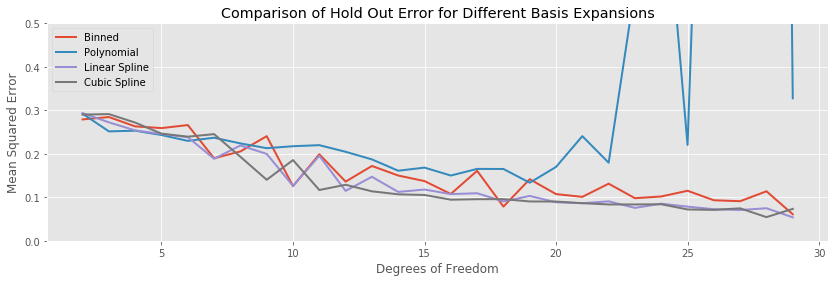

In [57]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_mean_errors[1], label="Binned")
ax.plot(degrees_of_freedom, polynomial_mean_errors[1], label="Polynomial")
ax.plot(degrees_of_freedom, pl_mean_errors[1], label="Linear Spline")
ax.plot(degrees_of_freedom, ncs_mean_errors[1], label="Cubic Spline")
ax.set_ylim(0.0, 0.5)

ax.legend()
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Comparison of Hold Out Error for Different Basis Expansions")

## Fitting to a weird signal

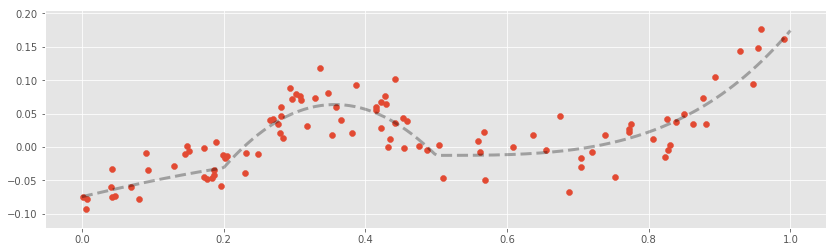

In [58]:
fig, ax = plt.subplots(figsize=(14, 4))
t = np.linspace(0, 1, num=250)

x = np.random.uniform(size=100)
y = weird_signal(x) + np.random.normal(scale=0.025, size=100)
ax.scatter(x, y)
ax.plot(t, weird_signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.3)

In [59]:
binned_mean_errors, binned_std_errors = run_simulation_expreiment(
    weird_signal, binned_regressors, sd=0.05)
polynomial_mean_errors, polynomial_std_errors = run_simulation_expreiment(
    weird_signal, polynomial_regressors, sd=0.05)
pl_mean_errors, pl_std_errors = run_simulation_expreiment(
    weird_signal, pl_regressors, sd=0.05)
ncs_mean_errors, ncs_std_errors = run_simulation_expreiment(
    weird_signal, ncs_regressors, sd=0.05)

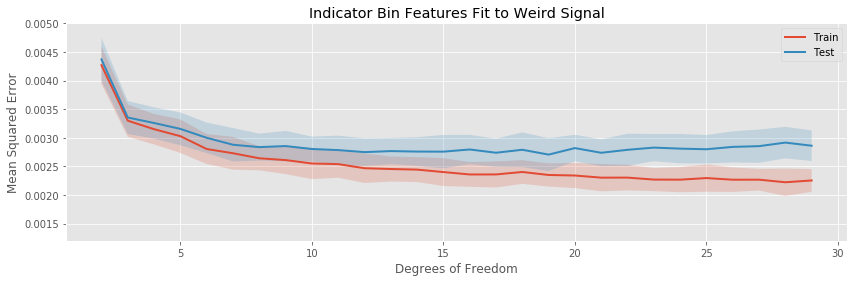

In [60]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, 
    degrees_of_freedom, binned_mean_errors, binned_std_errors)
ax.set_ylim(0.0012, 0.005)
ax.set_title("Indicator Bin Features Fit to Weird Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

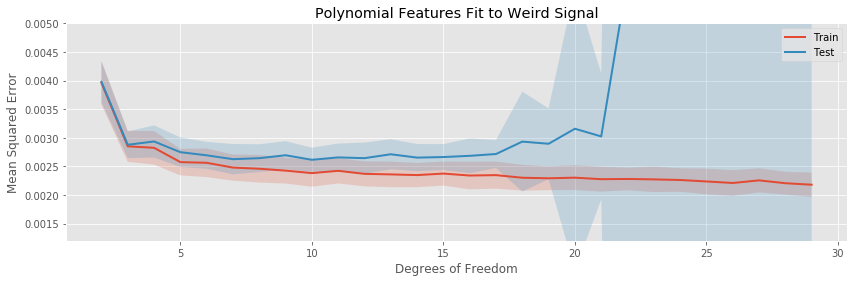

In [61]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, polynomial_mean_errors, polynomial_std_errors)
ax.set_ylim(0.0012, 0.005)
ax.set_title("Polynomial Features Fit to Weird Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

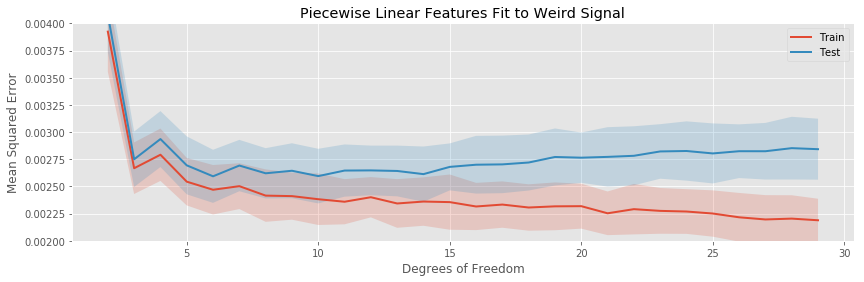

In [62]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, pl_mean_errors, pl_std_errors)
ax.set_ylim(0.002, 0.004)
ax.set_title("Piecewise Linear Features Fit to Weird Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

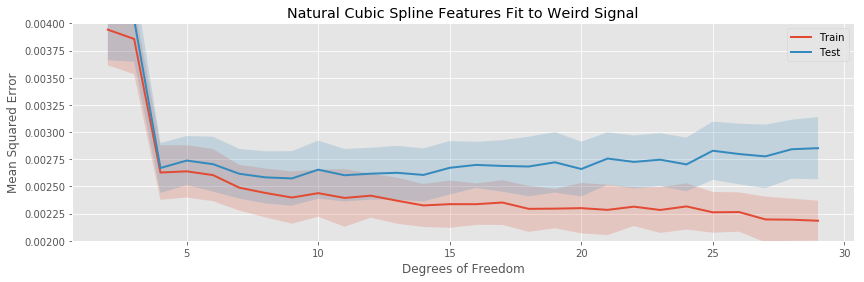

In [63]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, ncs_mean_errors, ncs_std_errors)
ax.set_ylim(0.002, 0.004)
ax.set_title("Natural Cubic Spline Features Fit to Weird Signal")
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")

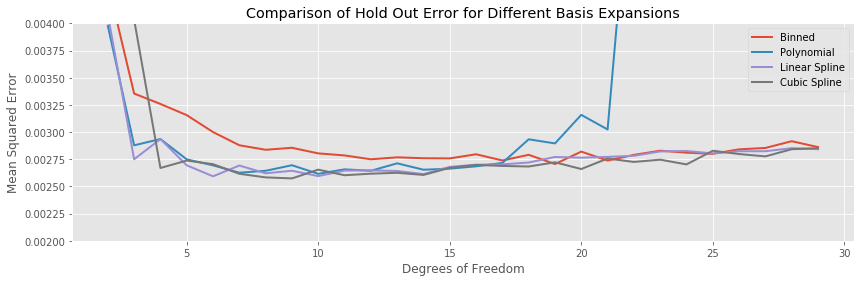

In [64]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_mean_errors[1], label="Binned")
ax.plot(degrees_of_freedom, polynomial_mean_errors[1], label="Polynomial")
ax.plot(degrees_of_freedom, pl_mean_errors[1], label="Linear Spline")
ax.plot(degrees_of_freedom, ncs_mean_errors[1], label="Cubic Spline")
ax.set_ylim(0.002, 0.004)

ax.legend()
ax.set_xlabel("Degrees of Freedom")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Comparison of Hold Out Error for Different Basis Expansions")